<h1 style="color:red;">Sentiment Analysis on IMDB Movie Reviews</h1>

## *Aim of the Project*

The aim of this project is to perform sentiment analysis on IMDB movie reviews. The goal is to build a **machine learning model** that classifies movie reviews into two categories: **positive** or **negative** sentiment. This will help in automatically determining how users feel about movies based on their written reviews. The ultimate objective is to provide a practical tool that can evaluate and predict sentiment on unseen text data, offering insights for businesses, content creators, or movie producers.

In [1]:
#Required Libraries for the project
import re
import string
import pandas as pd
import numpy as np
import pickle

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import  classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score,roc_auc_score, confusion_matrix,classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from wordcloud import WordCloud
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns 

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Importing dataset
df = pd.read_csv(r'P:\projects\Intelligent-Sentiment-Analyzer-Application\Data\train.csv',index_col=0)
df.head()

review_text sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive

# Exploratory Data Analysis

In [3]:
df.shape

(50000, 2)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   review_text  50000 non-null  object
 1   sentiment    50000 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


In [5]:
df.describe()

review_text sentiment
count                                               50000     50000
unique                                              49582         2
top     Loved today's show!!! It was a variety and not...  positive
freq                                                    5     25000

In [6]:
df.isnull().sum()

review_text    0
sentiment      0
dtype: int64

In [7]:
for i in range(3):
    print('Review: ',[i])
    print(df['review_text'].iloc[i], '\n')
    print('Sentiment: ', df['sentiment'].iloc[i], '\n\n')

Review:  [0]
One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is d

### As I can see, the review contains a lot of unnecessary text that will not contribute to sentiment analysis. So we need to clean it by removing HTML tags (\<br />), punctuations, numbers, and eliminating stopwords (e.g., "the", "is", "a") and converting text into lowercase. Additionally, lemmatization or stemming will be applied to standardize  the words. These steps ensure that our model will focuse only on meaningful words, and that will improve accuracy in sentiment classification.

In [8]:
df.duplicated().sum()

418

In [9]:
df = df.drop_duplicates()

In [10]:
#Number of words in each text review
def no_of_words(text):
    words = text.split()
    word_count = len(words)
    return word_count

df['word_count'] = df['review_text'].apply(no_of_words)

In [11]:
df.head()

review_text sentiment  word_count
0  One of the other reviewers has mentioned that ...  positive         307
1  A wonderful little production. <br /><br />The...  positive         162
2  I thought this was a wonderful way to spend ti...  positive         166
3  Basically there's a family where a little boy ...  negative         138
4  Petter Mattei's "Love in the Time of Money" is...  positive         230

<Axes: xlabel='word_count', ylabel='Count'>

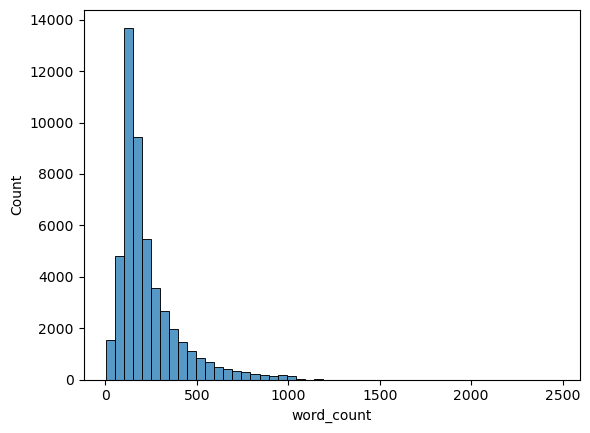

In [12]:
#the distribution of word counts in reviews
sns.histplot(df['word_count'], bins=50)

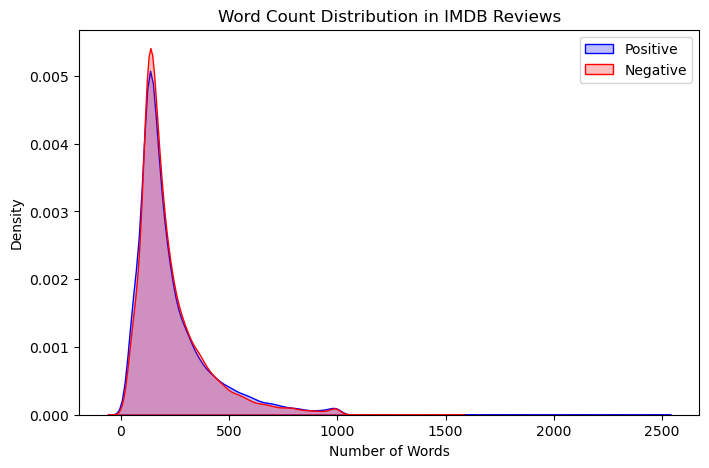

In [13]:
# Plot the distributions of word counts for positive and negative sentiments
plt.figure(figsize=(8, 5))
sns.kdeplot(df[df['sentiment'] == 'positive']['word_count'], label="Positive", color="blue", shade=True)
sns.kdeplot(df[df['sentiment'] == 'negative']['word_count'], label="Negative", color="red", shade=True)
plt.xlabel("Number of Words")
plt.ylabel("Density")
plt.title("Word Count Distribution in IMDB Reviews")
plt.legend()
plt.show()

In [14]:
#Length of reviews
df['review_length'] = df['review_text'].apply(len)
df.head()

review_text sentiment  word_count  \
0  One of the other reviewers has mentioned that ...  positive         307   
1  A wonderful little production. <br /><br />The...  positive         162   
2  I thought this was a wonderful way to spend ti...  positive         166   
3  Basically there's a family where a little boy ...  negative         138   
4  Petter Mattei's "Love in the Time of Money" is...  positive         230   

   review_length  
0           1761  
1            998  
2            926  
3            748  
4           1317

Text(0, 0.5, 'frequency')

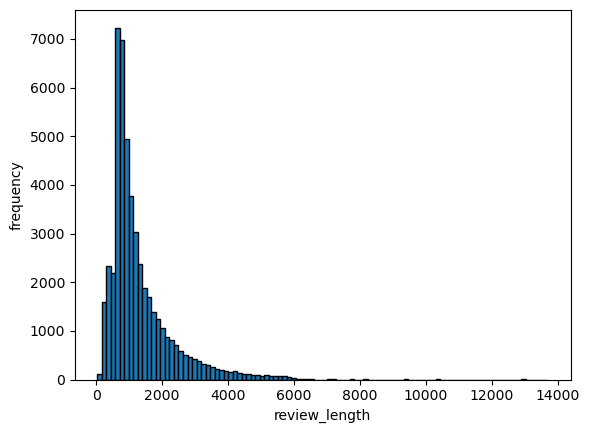

In [15]:
# Plot the distribution of reviews length
plt.hist(x='review_length',data=df,edgecolor = "black", bins = 100)
plt.xlabel('review_length')
plt.ylabel('frequency')

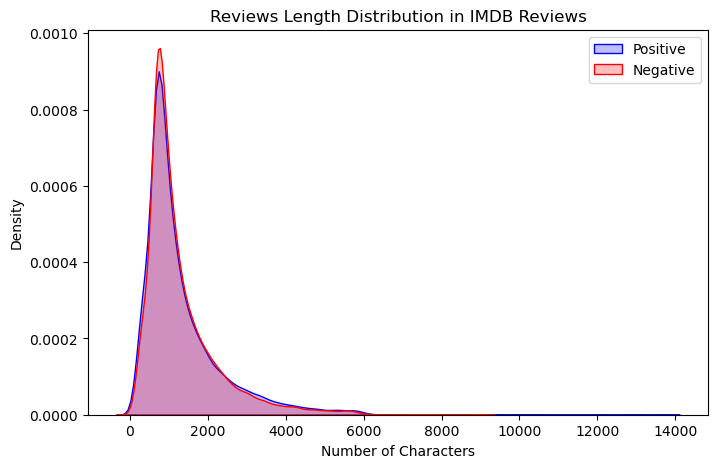

In [16]:
# Plot the distribution of reviews length for positive and negative reviews
plt.figure(figsize=(8, 5))
sns.kdeplot(df[df['sentiment'] == 'positive']['review_length'], label="Positive", color="blue", shade=True)
sns.kdeplot(df[df['sentiment'] == 'negative']['review_length'], label="Negative", color="red", shade=True)

# Labels and Title
plt.xlabel("Number of Characters")
plt.ylabel("Density")
plt.title("Reviews Length Distribution in IMDB Reviews")
plt.legend()
plt.show()

In [17]:
#Average length of reviews in positive & negative reviews
def plot_average_review_length(data):
    avg_length = data.groupby('sentiment')['review_length'].mean()
    print("\nAverage Review Length by Sentiment:")
    print(avg_length)

    # Plot average review length
    avg_length.plot(kind='bar', color=['skyblue', 'salmon'], edgecolor='black')
    plt.title('Average Review Length by Sentiment')
    plt.xlabel('Sentiment') 
    plt.ylabel('Average Review Length')
    plt.show()


Average Review Length by Sentiment:
sentiment
negative    1294.738967
positive    1326.277769
Name: review_length, dtype: float64


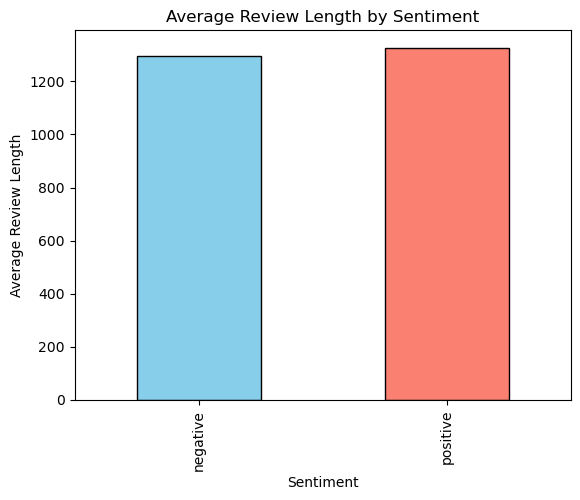

In [18]:
plot_average_review_length(df)

# Text Preprocessing

### 1. Text Cleaning

In [19]:
def clean_text(text):
    
    # remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    #Remove any square brackets and their content
    text=re.sub('\[.*?\]','',text)
    #removes all punctuation marks from the text
    text=re.sub('[%s]'%re.escape(string.punctuation),'',text)
    #removes words that contain numbers
    text=re.sub('\w*\d\w*','',text)
    text = re.sub(r'\s+', ' ', text)

    #Remove commas, single quotes, and double quotes
    text=re.sub('[''"",,,]','',text)    
    
    # convert text to lowercase and remove leading/trailing spaces
    text = text.lower().strip()
    return text

In [20]:
df['review_text']=df.review_text.apply(clean_text)
df.head()

review_text sentiment  word_count  \
0  one of the other reviewers has mentioned that ...  positive         307   
1  a wonderful little production the filming tech...  positive         162   
2  i thought this was a wonderful way to spend ti...  positive         166   
3  basically theres a family where a little boy j...  negative         138   
4  petter matteis love in the time of money is a ...  positive         230   

   review_length  
0           1761  
1            998  
2            926  
3            748  
4           1317

In [21]:
#see text after cleaning
for i in range(3):
    print('Review: ',[i])
    print(df['review_text'].iloc[i], '\n')

Review:  [0]
one of the other reviewers has mentioned that after watching just oz episode youll be hooked they are right as this is exactly what happened with methe first thing that struck me about oz was its brutality and unflinching scenes of violence which set in right from the word go trust me this is not a show for the faint hearted or timid this show pulls no punches with regards to drugs sex or violence its is hardcore in the classic use of the wordit is called oz as that is the nickname given to the oswald maximum security state penitentary it focuses mainly on emerald city an experimental section of the prison where all the cells have glass fronts and face inwards so privacy is not high on the agenda em city is home to manyaryans muslims gangstas latinos christians italians irish and moreso scuffles death stares dodgy dealings and shady agreements are never far awayi would say the main appeal of the show is due to the fact that it goes where other shows wouldnt dare forget pre

### 2. Removing stopwords

In [22]:
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    # print(stop_words)
    tokens = word_tokenize(text)
    # Remove stopwords
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(filtered_tokens)

In [23]:
df['review_text'] = df['review_text'].apply(remove_stopwords)

### 3. Convert words into its root word

In [24]:
stemmer = PorterStemmer()
def stemming(data):
    text = [stemmer.stem(word) for word in data]
    return data

df.review_text = df['review_text'].apply(lambda x: stemming(x))

## Final number of words and length of reviews after complete preprocessing

In [25]:
#final dataframe
df['word_count'] = df['review_text'].apply(no_of_words)

#Now length of characters after preprocessing
df['review_length'] = df['review_text'].apply(len)
df.head() 

review_text sentiment  word_count  \
0  one reviewers mentioned watching oz episode yo...  positive         167   
1  wonderful little production filming technique ...  positive          84   
2  thought wonderful way spend time hot summer we...  positive          85   
3  basically theres family little boy jake thinks...  negative          65   
4  petter matteis love time money visually stunni...  positive         125   

   review_length  
0           1157  
1            656  
2            587  
3            450  
4            863

In [26]:
df['review_text'][0]

'one reviewers mentioned watching oz episode youll hooked right exactly happened methe first thing struck oz brutality unflinching scenes violence set right word go trust show faint hearted timid show pulls punches regards drugs sex violence hardcore classic use wordit called oz nickname given oswald maximum security state penitentary focuses mainly emerald city experimental section prison cells glass fronts face inwards privacy high agenda em city home manyaryans muslims gangstas latinos christians italians irish moreso scuffles death stares dodgy dealings shady agreements never far awayi would say main appeal show due fact goes shows wouldnt dare forget pretty pictures painted mainstream audiences forget charm forget romanceoz doesnt mess around first episode ever saw struck nasty surreal couldnt say ready watched developed taste oz got accustomed high levels graphic violence violence injustice crooked guards wholl sold nickel inmates wholl kill order get away well mannered middle cl

# Some other analysis and plots

In [27]:
pos_reviews = df[df.sentiment == 'positive']
pos_reviews.head()

review_text sentiment  word_count  \
0  one reviewers mentioned watching oz episode yo...  positive         167   
1  wonderful little production filming technique ...  positive          84   
2  thought wonderful way spend time hot summer we...  positive          85   
4  petter matteis love time money visually stunni...  positive         125   
5  probably alltime favorite movie story selfless...  positive          56   

   review_length  
0           1157  
1            656  
2            587  
4            863  
5            394

Text(0.5, 1.0, 'Most frequent words in positive reviews')

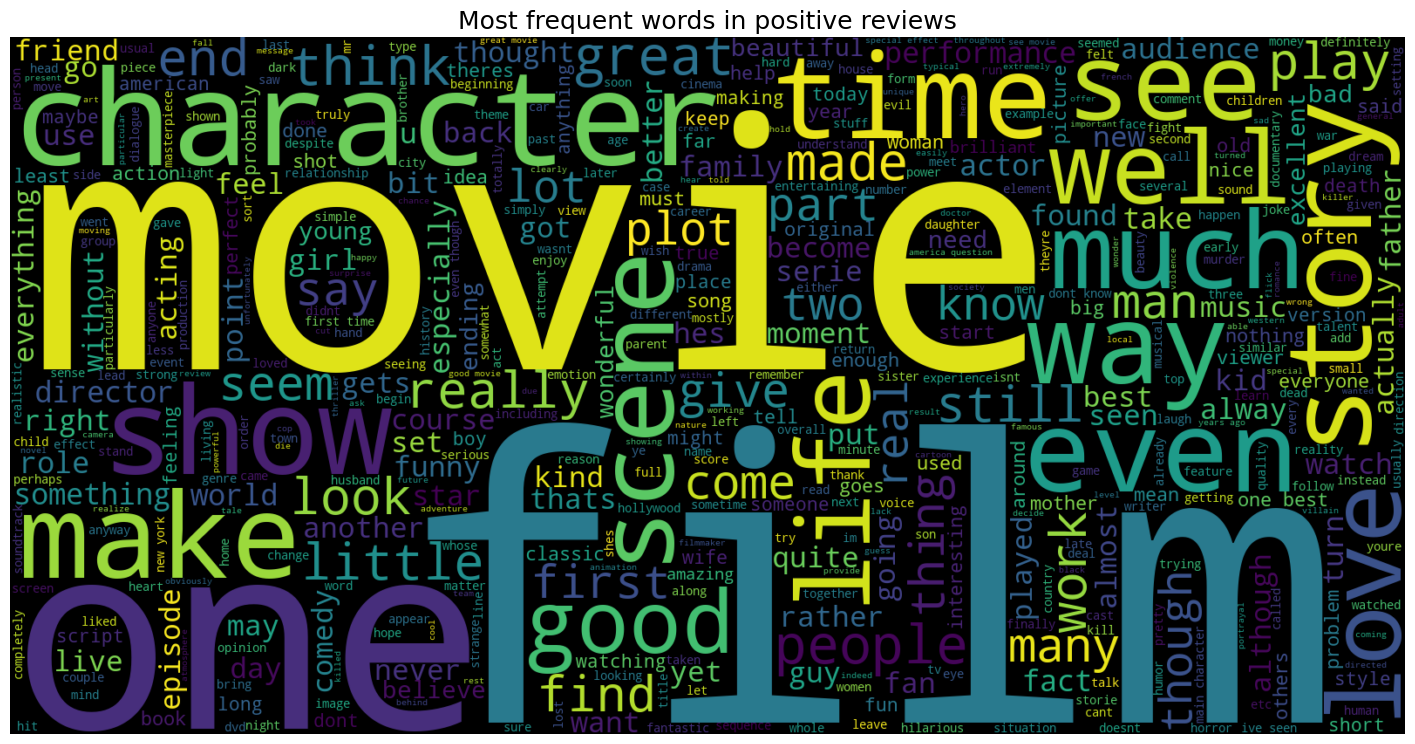

In [28]:
#Plot wordcloud
text = ' '.join([word for word in pos_reviews['review_text']])
plt.figure(figsize=(18,22), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off') 
plt.title('Most frequent words in positive reviews', fontsize=18)

In [29]:
#Top 10 frequent words in positive reviews
from collections import Counter
count = Counter()
for text in pos_reviews['review_text'].values:
    for word in text.split():
        count[word] += 1
count.most_common(10)

[('film', 39283),
 ('movie', 35833),
 ('one', 25619),
 ('like', 16998),
 ('good', 14286),
 ('great', 12570),
 ('story', 12340),
 ('see', 11813),
 ('time', 11724),
 ('well', 10932)]

In [30]:
pos_words = pd.DataFrame(count.most_common(10))
pos_words.columns = ['word','count']
pos_words.head()

word  count
0   film  39283
1  movie  35833
2    one  25619
3   like  16998
4   good  14286

In [31]:
#plot most frequent word in positive reviews
px.bar(pos_words, x='count',y='word',title='Common words in positive reviews',color='word')

In [32]:
neg_reviews = df[df.sentiment == 'negative']
neg_reviews.head()

review_text sentiment  word_count  \
3   basically theres family little boy jake thinks...  negative          65   
7   show amazing fresh innovative idea first aired...  negative          78   
8   encouraged positive comments film looking forw...  negative          62   
10  phil alien one quirky films humour based aroun...  negative          51   
11  saw movie came recall scariest scene big bird ...  negative          82   

    review_length  
3             450  
7             543  
8             405  
10            375  
11            553

Text(0.5, 1.0, 'Most frequent words in negative reviews')

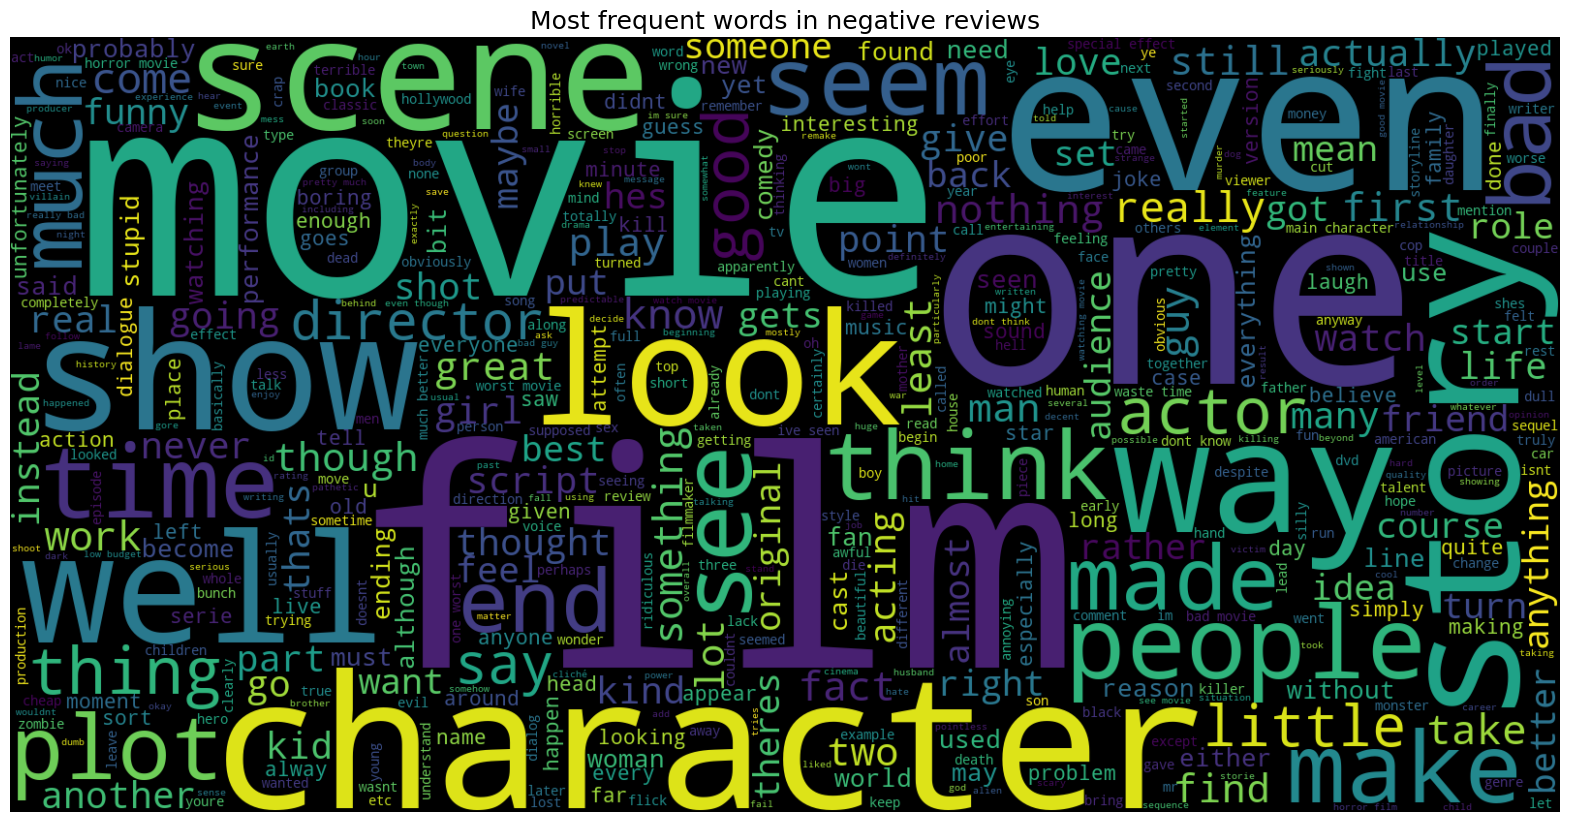

In [33]:
#Plot wordcloud
text = ' '.join([word for word in neg_reviews['review_text']])
plt.figure(figsize=(20,25), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off') 
plt.title('Most frequent words in negative reviews', fontsize=18)

In [34]:
#Top 10 frequent words in negative reviews
count = Counter()
for text in neg_reviews['review_text'].values:
    for word in text.split():
        count[word] += 1
count.most_common(10)

[('movie', 47008),
 ('film', 34658),
 ('one', 24365),
 ('like', 21507),
 ('even', 14760),
 ('good', 13997),
 ('bad', 13906),
 ('would', 13481),
 ('really', 12084),
 ('time', 11350)]

In [35]:
neg_words = pd.DataFrame(count.most_common(10))
neg_words.columns = ['word','count']
neg_words.head()

word  count
0  movie  47008
1   film  34658
2    one  24365
3   like  21507
4   even  14760

In [36]:
#plot most frequent words in negative reviews
px.bar(neg_words, x='count',y='word',title='Common words in positive reviews',color='word')

In [37]:
#Checking statistics by sentiment
df.groupby('sentiment').describe()

word_count                                                         \
               count        mean        std  min   25%   50%    75%     max   
sentiment                                                                     
negative     24698.0  117.127095  85.355894  3.0  64.0  89.0  142.0   794.0   
positive     24884.0  119.927222  93.026199  6.0  63.0  88.0  146.0  1416.0   

          review_length                                                       \
                  count        mean         std   min    25%    50%      75%   
sentiment                                                                      
negative        24698.0  816.847437  608.480754  17.0  439.0  612.0   995.75   
positive        24884.0  848.988507  675.978186  36.0  431.0  612.0  1038.25   

                   
              max  
sentiment          
negative   5677.0  
positive   9239.0

In [38]:
# count of unique values in the target feature
df['sentiment'].value_counts()

sentiment
positive    24884
negative    24698
Name: count, dtype: int64

In [39]:
#plot the sentiment distribution
def plot_sentiments_distribution(data):
    sentiment_counts = data['sentiment'].value_counts()
    sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')
    plt.title('Distribution of Sentiments')
    plt.xlabel('Sentiment')
    plt.ylabel('Number of Reviews')
    plt.show()

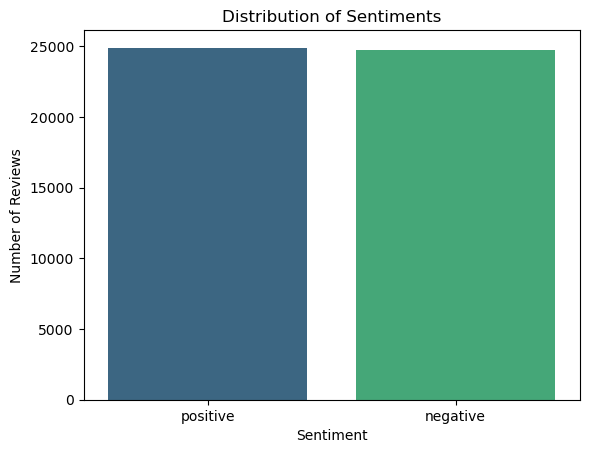

In [40]:
plot_sentiments_distribution(df)

**Since the dataset has balanced classes, the data points in negative and positive sentiments are almost equal so we can confidently evaluate the model performance without implementing imbalance handling techniques like oversampling or undersampling. This ensures a fair comparison of classification metrics without bias toward any class.**

In [41]:
df = df.drop(['word_count','review_length'],axis=1)
df.head()

review_text sentiment
0  one reviewers mentioned watching oz episode yo...  positive
1  wonderful little production filming technique ...  positive
2  thought wonderful way spend time hot summer we...  positive
3  basically theres family little boy jake thinks...  negative
4  petter matteis love time money visually stunni...  positive

In [42]:
# spliting dependent and independent features
X = df['review_text']
y = df['sentiment']

### Encoding categorical feature

In [43]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
y = encoder.fit_transform(y)

In [44]:
y

array([1, 1, 1, ..., 0, 0, 0])

In [45]:
#Splitting the dataset into train and test sets with 80:20
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [46]:
print('Size of X_train',(X_train.shape))
print('Size of y_train',(y_train.shape))
print('Size of X_test',(X_test.shape))
print('Size of y_test',(y_test.shape))

Size of X_train (39665,)
Size of y_train (39665,)
Size of X_test (9917,)
Size of y_test (9917,)


# Feature Extraction

In [47]:
tfidf = TfidfVectorizer(max_features=5000)

In [48]:
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)

In [49]:
X_train.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [50]:
X_test.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [51]:
# Storing vectorizer for prediction
pickle.dump(tfidf, open('models/vectorizer.pkl', 'wb'))

# Model Building & Evaluation

In [52]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Naïve Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

In [53]:
results = []

for name, model in models.items():
    # Training models
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]  
    
    # Compute evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    specificity = recall_score(y_test, y_pred, pos_label=0)  
    roc_auc = roc_auc_score(y_test, y_prob)

    # Save results
    results.append([name, accuracy, precision, recall, f1, specificity, roc_auc])

    # Print Metrics
    print(f"\n{name} Model Evaluation:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall (Sensitivity): {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    print('*'*40)


Logistic Regression Model Evaluation:
Accuracy: 0.8861
Precision: 0.8759
Recall (Sensitivity): 0.9006
F1-score: 0.8881
Specificity: 0.8714
ROC-AUC: 0.9541
****************************************

Naïve Bayes Model Evaluation:
Accuracy: 0.8459
Precision: 0.8431
Recall (Sensitivity): 0.8515
F1-score: 0.8473
Specificity: 0.8403
ROC-AUC: 0.9254
****************************************

Random Forest Model Evaluation:
Accuracy: 0.8379
Precision: 0.8428
Recall (Sensitivity): 0.8323
F1-score: 0.8375
Specificity: 0.8435
ROC-AUC: 0.9162
****************************************

XGBoost Model Evaluation:
Accuracy: 0.8436
Precision: 0.8281
Recall (Sensitivity): 0.8688
F1-score: 0.8480
Specificity: 0.8182
ROC-AUC: 0.9250
****************************************


In [54]:
#Final Results
results_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-score', 'Specificity', 'ROC-AUC'])
print("\nFinal Evaluation Metrics:\n")
results_df


Final Evaluation Metrics:



Model  Accuracy  Precision    Recall  F1-score  Specificity  \
0  Logistic Regression  0.886054   0.875928  0.900562  0.888074     0.871431   
1          Naïve Bayes  0.845921   0.843079  0.851547  0.847292     0.840251   
2        Random Forest  0.837854   0.842758  0.832262  0.837477     0.843491   
3              XGBoost  0.843602   0.828068  0.868823  0.847956     0.818182   

    ROC-AUC  
0  0.954086  
1  0.925418  
2  0.916207  
3  0.925016

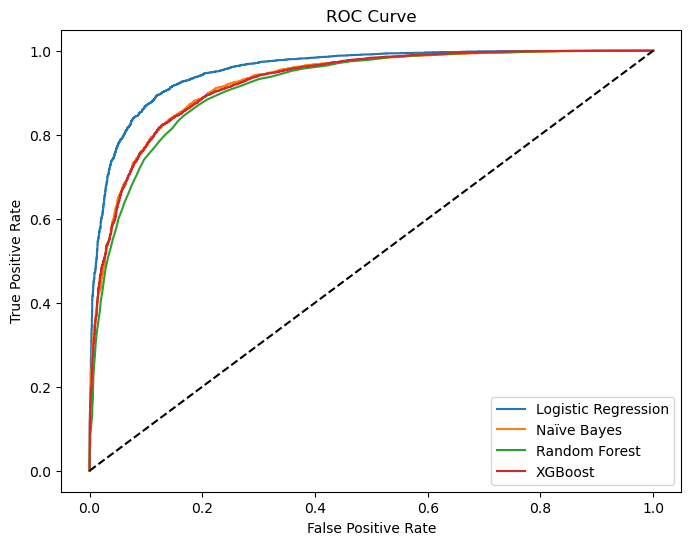

In [55]:
# Plot ROC Curve
plt.figure(figsize=(8,6))
for name, model in models.items():
    y_prob = model.predict_proba(X_test)[:, 1]
    from sklearn.metrics import roc_curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=name)

plt.plot([0,1], [0,1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

### Applying  Hyperparameter tuning for Logistic Regression

In [56]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  
    'solver': ['liblinear', 'lbfgs', 'saga'],  
    'max_iter': [100, 200, 500] 
}

In [57]:
# GridSearchCV
grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'max_iter': [100, 200, 500],
                         'solver': ['liblinear', 'lbfgs', 'saga']},
             scoring='accuracy')

In [58]:
# Best parameters
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'C': 1, 'max_iter': 500, 'solver': 'saga'}


In [63]:
model=LogisticRegression(
    C=1,
    max_iter=500,
    solver='saga',
    random_state=42)

model.fit(X_train,y_train)


y_pred = model.predict(X_test)
acc=accuracy_score(y_test,y_pred)
print(f"Accuracy: {acc:.2f} \n")

print(f"Classification Report: \n {classification_report(y_test,y_pred)}")

Accuracy: 0.89 

Classification Report: 
               precision    recall  f1-score   support

           0       0.90      0.87      0.88      4939
           1       0.88      0.90      0.89      4978

    accuracy                           0.89      9917
   macro avg       0.89      0.89      0.89      9917
weighted avg       0.89      0.89      0.89      9917



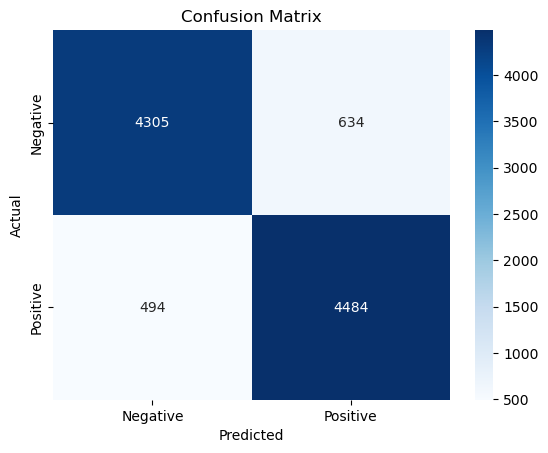

In [64]:
conf_mat=confusion_matrix(y_test,y_pred)
sns.heatmap(conf_mat,annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [65]:
# Save best model
best_model = grid_search.best_estimator_
pickle.dump(best_model, open("models/best_model.pkl", "wb"))

# Testing with the final model

In [66]:
with open("models/best_model.pkl", 'rb') as model_file:
        model = pickle.load(model_file)
        
with open('models/vectorizer.pkl', 'rb') as vectorizer_file:
        vectorizer = pickle.load(vectorizer_file) 

In [67]:
def clean_text(text):    
    text = re.sub(r'<.*?>', '', text)
    text=re.sub('\[.*?\]','',text)
    text=re.sub('[%s]'%re.escape(string.punctuation),'',text)
    text=re.sub('\w*\d\w*','',text)
    text = re.sub(r'\s+', ' ', text)
    text=re.sub('[''"",,,]','',text)
    text = text.lower().strip()
    return text

def predict(text):
    cleaned_text = clean_text(text)
    vectorized_text = vectorizer.transform([cleaned_text])
    prediction = model.predict(vectorized_text)[0]
    return "positive" if prediction == 1 else "negative"
    

In [68]:
sample_review = "This movie was absolutely fantastic! I loved every moment."
print("Review:", sample_review)
print("Predicted Sentiment:", predict(sample_review))

Review: This movie was absolutely fantastic! I loved every moment.
Predicted Sentiment: positive


In [70]:
#testing on large samples
large_samples=[
    "This movie was absolutely fantastic! I loved every moment.",
    "I love this movie, it's fantastic!",
    "Worst movie ever, I regret watching it.",
    "this movie is bad",
    'This movie is disgusting',
    "I don't like that movie",
    "Great movie! I really enjoyed it.",
    "This was a terrible film, so boring.",
    "Not bad, but could have been better."
  ]


for text in large_samples:
    print("Review:>>>", text)
    print("Predicted Sentiment:>>>", predict(text))
    print("*"*60)

Review:>>> This movie was absolutely fantastic! I loved every moment.
Predicted Sentiment:>>> positive
************************************************************
Review:>>> I love this movie, it's fantastic!
Predicted Sentiment:>>> positive
************************************************************
Review:>>> Worst movie ever, I regret watching it.
Predicted Sentiment:>>> negative
************************************************************
Review:>>> this movie is bad
Predicted Sentiment:>>> negative
************************************************************
Review:>>> This movie is disgusting
Predicted Sentiment:>>> negative
************************************************************
Review:>>> I don't like that movie
Predicted Sentiment:>>> negative
************************************************************
Review:>>> Great movie! I really enjoyed it.
Predicted Sentiment:>>> positive
************************************************************
Review:>>> This was a terrible

## Results
In this project, I implemented an end-to-end sentiment analysis pipeline using the IMDB Movie Reviews Dataset, where I applied various machine learning algorithms for text classification. The key results from my analysis and model evaluation is below:

- Best Model: Logistic Regression with highest accuracy 89%

The Logistic Regression model, combined with TF-IDF feature extraction, outperformed other traditional ML models, making it the most effective classifier for this task.

## Conclusion
The main motive behind this project was to construct a sentiment analysis model that will help to get a better understanding of movie reviews. For Evaluation, I observed the accuracy provided by each model. By evaluating the models, I found out that Logistic Regression gives the highest accuracy score of 89%.

## Future Work

In the next phase of this project, I am planning to enhance sentiment analysis performance by incorporating deep learning models such as LSTMs, and Transformer-based architectures like BERT etc. These advanced models will capture more contextual meaning and deeper semantic relationships, improving accuracy beyond traditional machine learning approaches.

Additionally, I will focus on building a more impressive and interactive UI application that provides a seamless user experience. The final application will be deployed on a cloud platform, ensuring accessibility, scalability, and real-time sentiment prediction. This future enhancement will transform the project into a fully functional, production-ready sentiment analysis system.

## Summary

Here's a summary of the step-by-step procedure I followed for Sentiment Analysis on IMDB Movie Reviews:

- Used the IMDB dataset containing 50,000 labeled movie reviews (positive/negative).

- Then I imported the data and started performing cleaning operations to preprocess the data.

- I eliminated the unwanted null values, duplicates, then stemmed each word to its root meaning.

- Then I have performed data analysis on our data to find interesting insights.

- Then perform feature selection and extraction.

- Classification using ML models like Logistic Regression etc.

- The evaluated the performance of classification using confusion matrix and classification report.

- And lastly Testing the final model.

<h1 style="color:green;">Happy Learning! 😊📚 & Stay Connected with me! 🌐🤝
for more.....</h1>